In [1]:
import json
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import lightgbm as lgb
import sklearn.model_selection as model_selection
import contextily as cx
import geopandas as gpd

gpd.io.file.fiona.drvsupport.supported_drivers["KML"] = "rw"

/Users/jimtotland/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# TODO:
- Try scaling the response differently
- Try transforming numerical features.

In [2]:
# Utils

def rmlse(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

## Creating feature square, park and metro distance

In [222]:
# import data 

# Read the apartment datasets
apartments_train = pd.read_csv("resources/data/apartments_train.csv").set_index("id")
apartments_train["split"] = "train"
apartments_test = pd.read_csv("resources/data/apartments_test.csv").set_index("id")
apartments_test["split"] = "test"

# Create a DataFrame of all apartments
apartments = pd.concat([apartments_train, apartments_test])

# Read the building datasets
buildings_train = pd.read_csv("resources/data/buildings_train.csv").set_index("id")
buildings_train["split"] = "train"
buildings_test = pd.read_csv("resources/data/buildings_test.csv").set_index("id")
buildings_test["split"] = "test"

# Create a GeoDataFrame of all buildings
buildings = pd.concat([buildings_train, buildings_test])
buildings = gpd.GeoDataFrame(buildings, geometry=gpd.points_from_xy(
    buildings.longitude, buildings.latitude, crs="EPSG:4326"
))

In [223]:
# Find all buildings missing coordinates
no_coords = buildings.latitude.isna() | buildings.longitude.isna()
street = buildings[~no_coords & (buildings.street == "пос. Коммунарка")]

buildings.loc[no_coords, "latitude"] = street.latitude.mean()
buildings.loc[no_coords, "longitude"] = street.longitude.mean()
buildings.loc[no_coords, "district"] = street.district.mode()[0]

In [224]:
# The coordinates of the southwest and northeast corners of a rectangle approximately encompassing Moscow
MOSCOW_SW_LAT = 55
MOSCOW_SW_LON = 35
MOSCOW_NE_LAT = 57
MOSCOW_NE_LON = 39

In [225]:
# Find all buildings with coordinates outside of Moscow
outside = (((buildings.latitude < MOSCOW_SW_LAT) | (buildings.latitude > MOSCOW_NE_LAT)
          | (buildings.longitude < MOSCOW_SW_LON) | (buildings.longitude > MOSCOW_NE_LON)))
buildings[outside][["split", "latitude", "longitude", "district", "street", "address", "constructed", "material", "stories"]]

for idx, building in buildings[outside].iterrows():
    street = buildings[~outside & (buildings.street == building.street)]
    if len(street):
        buildings.loc[idx, "latitude"] = street.latitude.mean()
        buildings.loc[idx, "longitude"] = street.longitude.mean()
        buildings.loc[idx, "district"] = street.district.mode()[0]
    else:
        buildings.loc[idx, "latitude"] = buildings[~outside].latitude.mean()
        buildings.loc[idx, "longitude"] = buildings[~outside].longitude.mean()

In [226]:
# Impute district
no_district = buildings.district.isna()
districts = buildings.loc[no_district].apply(
    lambda b: buildings.loc[
        (buildings[~no_district][["latitude", "longitude"]] - b[["latitude", "longitude"]]).abs().sum(axis=1).idxmin()
    ].district,
    axis=1
)
districts.rename("district", inplace=True)
buildings.update(districts)


In [228]:
# Find the mean and median construction year for each district
district_constructed_mean = buildings.groupby("district").constructed.mean().round()
district_constructed_median = buildings.groupby("district").constructed.median().round()

# Find the mean and median construction year for each street
street_constructed_mean = buildings.groupby("street").constructed.mean().round().dropna()
street_constructed_median = buildings.groupby("street").constructed.median().round().dropna()

# Add estimates for the buildings with missing constructions years
idx = ~buildings.constructed.isna()
buildings.loc[~idx, "constructed"] = buildings[~idx].apply(
    lambda b: street_constructed_median[b.street]
              if b.street in street_constructed_median
              else district_constructed_median[b.district],
    axis=1
)

In [232]:
stations = gpd.read_file("resources/metro_stations.kml", driver="KML").drop(columns=["Description"]).rename(columns={"Name": "name"})

# The Earth's radius in meters
EARTH_RADIUS = 6371000

# Create temporary columns for coordinates given in radians
stations["lon_rad"] = np.radians(stations.geometry.x)
stations["lat_rad"] = np.radians(stations.geometry.y)
buildings["lon_rad"] = np.radians(buildings.longitude)
buildings["lat_rad"] = np.radians(buildings.latitude)

# Calculate the distance to the nearest metro station for each building using
# the haversine formula with the Earth's radius as given above
metro_dist =  buildings.apply(
    lambda row:
            2 * EARTH_RADIUS
            * np.arcsin(
                np.sqrt(
                    np.sin((stations.lat_rad - row.lat_rad) / 2) ** 2
                    + np.cos(row.lat_rad)
                    * np.cos(stations.lat_rad)
                    * np.sin((stations.lon_rad - row.lon_rad) / 2) ** 2
            )), axis=1
)
buildings["metro_distance"] = np.min(metro_dist, axis = 1)

In [259]:
metro_close = np.sum(metro_dist < 1000, axis = 1)
buildings['metro_close'] = metro_close

In [70]:
metro_close.mean()

1.0562641431804156

In [233]:
# Read park and garden location data
parks = gpd.read_file("resources/parks_and_gardens.kml", driver="KML").drop(columns=["Description"]).rename(columns={"Name": "name"})

# Create columns for coordinates given in radians
parks["lon_rad"] = np.radians(parks.geometry.x)
parks["lat_rad"] = np.radians(parks.geometry.y)

# Calculate the distance to the nearest park or garden for each building using
# the haversine formula with the Earth's radius as given above
park_dist = buildings.apply(
    lambda row:
        2
        * EARTH_RADIUS
        * np.arcsin(
            np.sqrt(
                np.sin((parks.lat_rad - row.lat_rad) / 2) ** 2
                + np.cos(row.lat_rad)
                * np.cos(parks.lat_rad)
                * np.sin((parks.lon_rad - row.lon_rad) / 2) ** 2
            )
        ), axis = 1
    )


buildings["park_distance"] = np.min(park_dist, axis = 1)


In [234]:
buildings['park_close']  = np.sum(park_dist < 2000, axis = 1)

In [103]:
buildings_train = buildings.loc[buildings.split == 'train']
data = pd.merge(apartments, buildings_train, how='left', left_on='building_id', right_index=True)
data['log_price'] = np.log(data.price)

In [104]:
data['log_price'].corr(data.park_close)

0.40533854592953783

In [235]:
# Read square location data
squares = gpd.read_file("resources/squares.kml", driver="KML").drop(columns=["Description"]).rename(columns={"Name": "name"})

# Create columns for coordinates given in radians
squares["lon_rad"] = np.radians(squares.geometry.x)
squares["lat_rad"] = np.radians(squares.geometry.y)

# Calculate the distance to the nearest square for each building using the
# haversine formula with the Earth's radius as given above

square_dist = buildings.apply(
    lambda row: 
        2
        * EARTH_RADIUS
        * np.arcsin(
            np.sqrt(
                np.sin((squares.lat_rad - row.lat_rad) / 2) ** 2
                + np.cos(row.lat_rad)
                * np.cos(squares.lat_rad)
                * np.sin((squares.lon_rad - row.lon_rad) / 2) ** 2
            )
        ), 
    axis=1
)

buildings["square_distance"] = np.min(square_dist, axis = 1)

# Drop the temporary radian columns
#stations.drop(columns=["lon_rad", "lat_rad"], inplace=True)
#buildings.drop(columns=["lon_rad", "lat_rad"], inplace=True)

In [236]:
buildings['square_close']  = np.sum(square_dist < 3000, axis = 1)

In [109]:
buildings_train = buildings.loc[buildings.split == 'train']
data = pd.merge(apartments, buildings_train, how='left', left_on='building_id', right_index=True)
data['log_price'] = np.log(data.price)

In [110]:
data['log_price'].corr(data.square_close)

0.40675613513606784

In [237]:
rublevka_lat = 55.73870
rublevka_lon = 37.25904
rublevka_lat_rad = np.radians(rublevka_lat)
rublevka_lon_rad = np.radians(rublevka_lon)

rublevka_dist = buildings.apply(
    lambda row: 
        2
        * EARTH_RADIUS
        * np.arcsin(
            np.sqrt(
                np.sin((rublevka_lat_rad - row.lat_rad) / 2) ** 2
                + np.cos(row.lat_rad)
                * np.cos(rublevka_lat_rad)
                * np.sin((rublevka_lon_rad - row.lon_rad) / 2) ** 2
            )
        ), 
    axis=1
)

In [238]:
buildings['rublevka_dist'] = rublevka_dist

In [239]:
ostoz_lat = 55.74041592186014
ostoz_lon = 37.59606083068356
ostoz_lat_rad = np.radians(ostoz_lat)
ostoz_lon_rad = np.radians(ostoz_lon)

ostoz_dist = buildings.apply(
    lambda row: 
        2
        * EARTH_RADIUS
        * np.arcsin(
            np.sqrt(
                np.sin((ostoz_lat_rad - row.lat_rad) / 2) ** 2
                + np.cos(row.lat_rad)
                * np.cos(ostoz_lat_rad)
                * np.sin((ostoz_lon_rad - row.lon_rad) / 2) ** 2
            )
        ), 
    axis=1
)

In [240]:
buildings['ostoz_dist'] = ostoz_dist

In [241]:
khamo_lat = 55.733078399352074
khamo_lon = 37.574861386328806
khamo_lat_rad = np.radians(khamo_lat)
khamo_lon_rad = np.radians(khamo_lon)

khamo_dist = buildings.apply(
    lambda row: 
        2
        * EARTH_RADIUS
        * np.arcsin(
            np.sqrt(
                np.sin((khamo_lat_rad - row.lat_rad) / 2) ** 2
                + np.cos(row.lat_rad)
                * np.cos(khamo_lat_rad)
                * np.sin((khamo_lon_rad - row.lon_rad) / 2) ** 2
            )
        ), 
    axis=1
)

In [242]:
buildings['khamo_dist'] = khamo_dist

In [243]:
yaki_lat = 55.732884073626586
yaki_lon = 37.610828401028435
yaki_lat_rad = np.radians(yaki_lat)
yaki_lon_rad = np.radians(yaki_lon)

yaki_dist = buildings.apply(
    lambda row: 
        2
        * EARTH_RADIUS
        * np.arcsin(
            np.sqrt(
                np.sin((yaki_lat_rad - row.lat_rad) / 2) ** 2
                + np.cos(row.lat_rad)
                * np.cos(yaki_lat_rad)
                * np.sin((yaki_lon_rad - row.lon_rad) / 2) ** 2
            )
        ), 
    axis=1
)

buildings['yaki_dist'] = yaki_dist

In [244]:
arbat_lat = 55.751646651040474
arbat_lon = 37.601199713824386
arbat_lat_rad = np.radians(arbat_lat)
arbat_lon_rad = np.radians(arbat_lon)

arbat_dist = buildings.apply(
    lambda row: 
        2
        * EARTH_RADIUS
        * np.arcsin(
            np.sqrt(
                np.sin((arbat_lat_rad - row.lat_rad) / 2) ** 2
                + np.cos(row.lat_rad)
                * np.cos(arbat_lat_rad)
                * np.sin((arbat_lon_rad - row.lon_rad) / 2) ** 2
            )
        ), 
    axis=1
)

buildings['arbat_dist'] = arbat_dist

In [245]:
pres_lat = 55.7638390539512
pres_lon = 37.559469484210624
pres_lat_rad = np.radians(pres_lat)
pres_lon_rad = np.radians(pres_lon)

pres_dist = buildings.apply(
    lambda row: 
        2
        * EARTH_RADIUS
        * np.arcsin(
            np.sqrt(
                np.sin((pres_lat_rad - row.lat_rad) / 2) ** 2
                + np.cos(row.lat_rad)
                * np.cos(pres_lat_rad)
                * np.sin((pres_lon_rad - row.lon_rad) / 2) ** 2
            )
        ), 
    axis=1
)

buildings['pres_dist'] = pres_dist

In [246]:
tver_lat = 55.76960731290398
tver_lon = 37.608153625557165
tver_lat_rad = np.radians(tver_lat)
tver_lon_rad = np.radians(tver_lon)

tver_dist = buildings.apply(
    lambda row: 
        2
        * EARTH_RADIUS
        * np.arcsin(
            np.sqrt(
                np.sin((tver_lat_rad - row.lat_rad) / 2) ** 2
                + np.cos(row.lat_rad)
                * np.cos(tver_lat_rad)
                * np.sin((tver_lon_rad - row.lon_rad) / 2) ** 2
            )
        ), 
    axis=1
)

buildings['tver_dist'] = tver_dist

In [260]:
all_data = data = apartments.reset_index().merge(
    buildings, how="left", left_on=["building_id", "split"], right_on=["id", "split"]
).set_index("id")

In [261]:
all_data['bathrooms_total'] = all_data.bathrooms_private + all_data.bathrooms_shared
all_data['ballog'] = all_data.loggias + all_data.balconies

In [270]:
ceiling_fix2 = all_data.ceiling_fix
ceiling_fix2.loc[ceiling_fix2 > 50] = ceiling_fix2[ceiling_fix2 > 50]/100
ceiling_fix2.loc[ceiling_fix2 > 10] = ceiling_fix2.loc[ceiling_fix2 > 10]/10
ceiling_fix2.loc[ceiling_fix2 < 1.6] = ceiling_fix2.mean()
all_data['ceiling_fix2'] = ceiling_fix2


/Users/jimtotland/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/jimtotland/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/jimtotland/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [263]:
all_data['price_per_sqm'] = all_data.price/all_data.area_total
avg_price_per_sqm = all_data.groupby('district').agg('mean')['price_per_sqm']

distr_avg = np.empty(all_data.shape[0])
for i in range(all_data.shape[0]):
    distr_avg[i] = avg_price_per_sqm[int(all_data.district[i])]
all_data['distr_avg'] = distr_avg

In [264]:
all_data['log_area_total'] = np.log(all_data.area_total)

In [265]:
all_data['log_area_per_room'] = np.log(all_data.area_total/all_data.rooms)

In [266]:
all_data['floor_fix'] = all_data.floor
floor_idx = all_data.floor > all_data.stories
all_data.loc[floor_idx, 'floor_fix'] = all_data.loc[floor_idx, 'stories']

In [218]:
data = all_data.loc[all_data.split == 'train']

In [221]:
data['price'].corr(data.floor)

0.13220646015750626

In [271]:
all_data.to_csv("all_data_h4.csv")

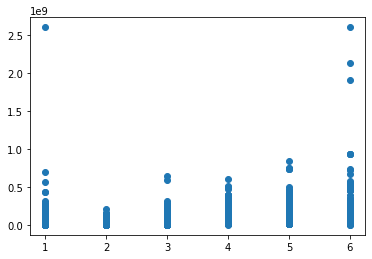

In [275]:
plt.scatter(all_data.rooms, all_data.price)

In [278]:
all_data.loc[(all_data.rooms ==1) & (all_data.price > 2e09)]

,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,...,metro_close,bathrooms_total,ballog,ceiling_fix,price_per_sqm,distr_avg,log_area_total,log_area_per_room,floor_fix,ceiling_fix2
id,,,,,,,,,,,,,,,,,,,,,
21414,NaN,2.600000e+09,2181.0,NaN,NaN,95.0,1.0,NaN,3.5,NaN,...,5,NaN,NaN,3.5,1.192114e+06,546695.648414,7.687539,7.687539,95.0,3.5


In [285]:
all_data.loc[all_data.split == 'test'].area_total.max()

1175.0

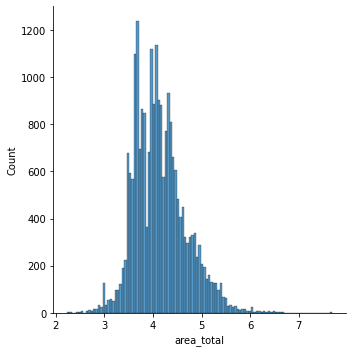

In [288]:
sns.displot(np.log(all_data.loc[all_data.split == 'train'].area_total))

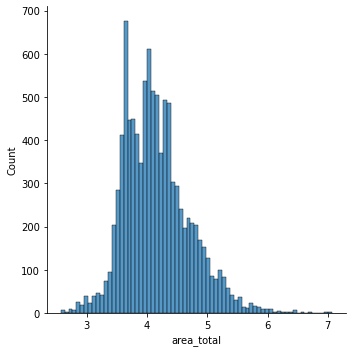

In [289]:
sns.displot(np.log(all_data.loc[all_data.split == 'test'].area_total))

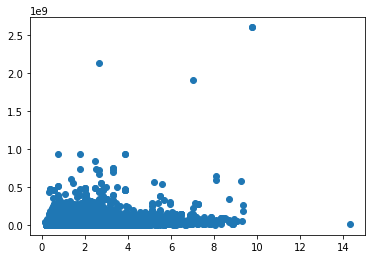

In [291]:
plt.scatter(all_data.floor/np.sqrt(all_data.stories), all_data.price)

## Some data cleaning and feature engineering

In [15]:
# Imputing area_living
from sklearn import linear_model
missing_idx = data['area_living'].isna()
model = linear_model.LinearRegression()
model.fit(X = data.loc[~missing_idx, ['area_total', 'rooms']], y = data.loc[~missing_idx, 'area_living'])
data.loc[missing_idx, 'area_living'] = model.predict(data.loc[missing_idx, ['area_total', 'rooms']])

missing_idx_test = data_test['area_living'].isna()
data_test.loc[missing_idx_test, 'area_living'] = model.predict(data_test.loc[missing_idx_test, ['area_total', 'rooms']])

In [12]:
# feature ballog
data['ballog'] = data['loggias'] + data['balconies']
data_test['ballog'] = data_test['loggias'] + data_test['balconies']

In [17]:
# featrure elevator
a = np.empty(data.shape[0])
for i in range(data.shape[0]):
    ep = data['elevator_passenger'][i]
    ew = data['elevator_without'][i]
    es = data['elevator_service'][i]
    ep_val, ew_val, es_val = 0, 0, 0
    if ep:
        ep_val = 1
    else:
        ep_val = 0
    if es:
        es_val = 1
    else:
        es_val = 0
    val = ep_val + es_val
    a[i] = val
data['elevator'] = a

b = np.empty(data_test.shape[0])
for i in range(data_test.shape[0]):
    ep = data_test['elevator_passenger'][i]
    es = data_test['elevator_service'][i]
    ep_val, ew_val, es_val = 0, 0, 0
    if ep:
        ep_val = 1
    else:
        ep_val = 0
    if es:
        es_val = 1
    else:
        es_val = 0
    val = ep_val + es_val
    b[i] = val
data_test['elevator'] = b

In [13]:
data['bathrooms_total'] = data['bathrooms_private'] + data['bathrooms_shared']
data_test['bathrooms_total'] = data_test['bathrooms_private'] + data_test['bathrooms_shared']

In [19]:
windows = np.empty(data.shape[0])
windows[:] = np.nan
for i in range(data.shape[0]):
    wc = data['windows_court'][i]
    ws = data['windows_street'][i]
    if(not pd.isna(wc)):
        if(wc and ws):
            windows[i] = 3
        elif(ws and not wc):
            windows[i] = 2
        elif(not ws and wc):
            windows[i] = 1
        else:
            windows[i] = 0
data['windows'] = windows

windows = np.empty(data_test.shape[0])
windows[:] = np.nan
for i in range(data_test.shape[0]):
    wc = data_test['windows_court'][i]
    ws = data_test['windows_street'][i]
    if(not pd.isna(wc)):
        if(wc and ws):
            windows[i] = 3
        elif(ws and not wc):
            windows[i] = 2
        elif(not ws and wc):
            windows[i] = 1
        else:
            windows[i] = 0
data_test['windows'] = windows

In [24]:
# binning of district_enc

district_bin = np.empty(data.shape[0])
for i in range(data.shape[0]):
    d = data['district_enc'][i]
    b = 0
    if(d == 1 or d == 2):
        b = 1
    elif(d == 3 or d== 4):
        b = 2
    elif(d == 5 or d== 6 or d== 7):
        b = 3
    elif(d == 8 or d == 9):
        b = 4
    elif( d== 10):
        b = 5
    elif(d == 11):
        b = 6
    district_bin[i] = b

data['district_bin'] = district_bin
data['district_bin'] = data['district_bin'].astype(int)

district_bin = np.empty(data_test.shape[0])
for i in range(data_test.shape[0]):
    d = data_test['district_enc'][i]
    b = 0
    if(d == 1 or d == 2):
        b = 1
    elif(d == 3 or d== 4):
        b = 2
    elif(d == 5 or d== 6 or d== 7):
        b = 3
    elif(d == 8 or d == 9):
        b = 4
    elif( d== 10):
        b = 5
    elif(d == 11):
        b = 6
    district_bin[i] = b

data_test['district_bin'] = district_bin
data_test['district_bin'] = data_test['district_bin'].astype(int)

In [23]:
# Re-encoding district by mean value
agg = data.groupby('district').aggregate('mean')['price'].sort_values(ascending = True)
encoding = dict()
for i in range(12):
    encoding[agg.index[i]] = i
encoding

data['district_enc'] = np.empty(data.shape[0])
for i in range(data.shape[0]):
    if(not pd.isna(data['district'][i])):
        data['district_enc'][i] = encoding[data['district'][i]]

data_test['district_enc'] = np.empty(data_test.shape[0])
for i in range(data_test.shape[0]):
    if(not pd.isna(data_test['district'][i])):
        data_test['district_enc'][i] = encoding[data_test['district'][i]]

/Users/jimtotland/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/jimtotland/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


## Optuna with LightGBM
Below are different tree-ensamble models combined with optuna.

 
## Best submission so far:
- crossval-score: 0.12700260767163787
- features = ['latitude', 'longitude', 'constructed', 'area_kitchen', 'area_living', 'area_per_room', 'rooms', 'ballog', 'district', 'park_distance',
            'material', 'condition', 'heating', 'stories', 'floor', 'ceiling', 'bathrooms_total', 'windows']
- trees: 5000
- params: {'reg_alpha': 0.09843863733920495, 'reg_lambda': 0.0034831755346420713, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.03, 'max_depth': 100, 'num_leaves': 764, 'min_child_samples': 8, 'cat_smooth': 28}

In [33]:
import optuna 
from sklearn.model_selection import KFold
from optuna.integration import LightGBMPruningCallback

def objective_lgb(trial, X, y, price_per_sqm, area, logprice_per_sqm):
    params = {
        'verbose': -1,
        'metric': 'rmse', 
        'random_state': 42,
        'n_estimators': 7000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02, 0.03]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('cat_smooth', 3, 60)
    }
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    pruning_callback = LightGBMPruningCallback(trial, "rmse")

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_test = y[test_idx]
        y_train = np.log(price_per_sqm[train_idx])
        #y_train = logprice_per_sqm[train_idx]

        lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
        #X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify = round(y_train), random_state=42)
        #lgb_train = lgb.Dataset(X_tr, y_tr, free_raw_data=False)
        #lgb_eval = lgb.Dataset(X_val, y_val,free_raw_data=False)
        model = lgb.train(params, 
            lgb_train, categorical_feature= CATEGORICAL_FEATURES) #callbacks = [pruning_callback])
    
        preds = np.exp(model.predict(X_test)) * area[test_idx]
        #preds = np.exp(model.predict(X_test) * area[test_idx]) 
        cv_scores[idx] = rmlse(y_test, preds)
    
    return np.mean(cv_scores)

In [47]:
NUMERIC_FEATURES = ["latitude", "longitude", "constructed", "area_total",
            "rooms", "balconies", "loggias", "metro_distance", "park_distance",
            "square_distance", "stories","floor", "ceiling", "bathrooms_shared", "bathrooms_private", ]
CATEGORICAL_FEATURES = ["seller", "district", "material", "condition", "heating", "new", 
                "layout", "windows_court", "windows_street", "parking", "garbage_chute", "elevator_passenger", "elevator_without", "elevator_service"]
data[CATEGORICAL_FEATURES] = data[CATEGORICAL_FEATURES].astype('category')
data_test[CATEGORICAL_FEATURES] = data_test[CATEGORICAL_FEATURES].astype('category')
FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES

In [41]:
from scipy.stats import skew

skewed_feats = data[NUMERIC_FEATURES].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
print(skewed_feats)

df_scaled = data.copy()
df_scaled[skewed_feats] = np.log1p(df_scaled[skewed_feats])

df_scaled_test = data_test.copy()
df_scaled_test[skewed_feats] = np.log1p(df_scaled_test[skewed_feats])

Index(['area_total', 'rooms', 'balconies', 'loggias', 'metro_distance',
       'park_distance', 'square_distance', 'stories', 'floor', 'ceiling',
       'bathrooms_shared', 'bathrooms_private'],
      dtype='object')


In [48]:
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

lgb_features = ['latitude', 'longitude', 'constructed', 'area_total', 'square_distance', 'area_kitchen', 'area_living', 'area_per_room', 'rooms', 'ballog', 'district', 'park_distance',
            'material', 'condition', 'heating', 'stories', 'floor', 'ceiling', 'bathrooms_total']
X = df_scaled[FEATURES]   
y = df_scaled['price']
area = data['area_total']
price_per_sqm = data['price_per_sqm']

study = optuna.create_study(direction="minimize", study_name="LGBM Regressor")
func = lambda trial: objective_lgb(trial, X, y, price_per_sqm, area, logprice_per_sqm)
study.optimize(func, n_trials=30)

[I 2021-11-08 11:07:37,232] A new study created in memory with name: LGBM Regressor
[I 2021-11-08 11:10:38,631] Trial 0 finished with value: 0.12927186486967684 and parameters: {'reg_alpha': 0.02925623451088391, 'reg_lambda': 0.005865597637152054, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 931, 'min_child_samples': 72, 'cat_smooth': 18}. Best is trial 0 with value: 0.12927186486967684.
[I 2021-11-08 11:13:58,619] Trial 1 finished with value: 0.13513477937974183 and parameters: {'reg_alpha': 2.2563527227863105, 'reg_lambda': 0.058216994249771156, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 167, 'min_child_samples': 175, 'cat_smooth': 18}. Best is trial 0 with value: 0.12927186486967684.
[I 2021-11-08 11:15:20,494] Trial 2 finished with value: 0.13331229051104782 and parameters: {'reg_alpha': 0.0011351343752604662, 'reg_lambda': 0.03502484261237601, 'colsample_bytree': 0.3, 'subsa

KeyboardInterrupt: 

In [43]:
X_train = df_scaled[FEATURES]
y_train = np.log(data.price_per_sqm)
#y_tain = logprice_per_sqm

#params = {'reg_alpha': 0.09843863733920495, 'reg_lambda': 0.0034831755346420713, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.03, 'max_depth': 100, 'num_leaves': 764, 'min_child_samples': 8, 'cat_smooth': 28}

lgb_mod = lgb.LGBMRegressor(
    random_state = 42,
    metric='rmse',
    n_estimators= 7000,
    categorical_feature = CATEGORICAL_FEATURES,
    **study.best_params
)

lgb_mod.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', cat_smooth=34,
              categorical_feature=['seller', 'district', 'material',
                                   'condition', 'heating', 'new', 'layout',
                                   'windows_court', 'windows_street', 'parking',
                                   'garbage_chute', 'elevator_passenger',
                                   'elevator_without', 'elevator_service'],
              class_weight=None, colsample_bytree=0.4, importance_type='split',
              learning_rate=0.01, max_depth=100, metric='rmse',
              min_child_samples=39, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=7000, n_jobs=-1, num_leaves=375, objective=None,
              random_state=42, reg_alpha=0.0015037481382252393,
              reg_lambda=1.3915768491798648, silent=True, subsample=0.7,
              subsample_for_bin=200000, subsample_freq=0)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

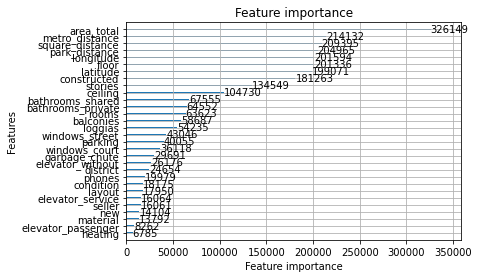

In [44]:
lgb.plot_importance(lgb_mod)

In [45]:
preds_test = np.exp(lgb_mod.predict(df_scaled_test[FEATURES])) * data_test['area_total']
# #preds_test = np.exp(lgb_mod.predict(data_test[features]) * data_test['area_total'])
submission = pd.DataFrame()
submission['id'] = data_test.id
submission['price_prediction'] = preds_test
submission.to_csv('submissions/lgbm_submission.csv', index=False)

In [46]:
submission

,id,price_prediction
0,23285,3.064811e+07
1,23286,9.728509e+06
2,23287,6.142217e+06
3,23288,8.448656e+06
4,23289,5.346999e+06
...,...,...
9932,33217,2.965242e+07
9933,33218,1.772865e+07
9934,33219,9.519171e+06
9935,33220,9.680705e+06


## Optuna with XGBoost

In [89]:
import xgboost as xgb 

def objective_xgb(trial, X, y, area):
    '''
    param = {
        "objective": "reg:squaredlogerror",
        "eval_metric": "rmse",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
    }
    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)
    '''
    param = {   'booster': 'gbtree',
                'max_depth':trial.suggest_int('max_depth', 1, 11),
                'reg_alpha':trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
                'reg_lambda':trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
                'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
                'gamma':trial.suggest_int('gamma', 0, 5),
                'learning_rate':trial.suggest_loguniform('learning_rate',0.001,0.5),
                'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.1,1,0.01),
                'nthread' : -1
    }

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-rmse")
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = np.log(y[train_idx]/area[train_idx]), np.log(y[test_idx]/area[test_idx])

        dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
        dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
        model = xgb.train(param, dtrain, num_boost_round=2000, evals=[(dtest, "validation")], verbose_eval=False, callbacks=[pruning_callback])
    
        preds = np.exp(model.predict(dtest)) * area[test_idx]
        cv_scores[idx] = rmlse(np.exp(y_test)*area[test_idx], preds)
    
    return np.mean(cv_scores)

In [54]:
from sklearn.model_selection import KFold


def objective_xgb_sklearn(trial, X, y, area, random_state=42, n_splits=5, n_jobs=-1, early_stopping_rounds=200):

    param = {   'booster': 'gbtree',
                'max_depth':trial.suggest_int('max_depth', 1, 11),
                'reg_alpha':trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
                'reg_lambda':trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
                'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
                'gamma':trial.suggest_int('gamma', 0, 5),
                'learning_rate':trial.suggest_loguniform('learning_rate',0.001,0.5),
                'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.1,1,0.01),
                'nthread' : -1
    }

    model = xgb.XGBRegressor(**param)
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_0-rmse")

    cv = KFold(n_splits= n_splits, shuffle=True, random_state= random_state)
    cv_scores = np.empty(n_splits)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = np.log(y[train_idx]/area[train_idx]), y[test_idx]
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="rmse",
            verbose=0,
            callbacks=[pruning_callback],
            early_stopping_rounds=early_stopping_rounds
        )
        preds = np.exp(model.predict(X_test)) * area[test_idx]
        cv_scores[idx] = rmlse(y_test, preds)
        
    return np.mean(cv_scores)

In [80]:
from sklearn.model_selection import train_test_split
def objective_light(trial, X, y):
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.33, stratify=np.log(data.price).round())
    dtrain = xgb.DMatrix(train_x, label= np.log(train_y))
    dtest = xgb.DMatrix(test_x, label=test_y)

    param = {   'booster': 'gbtree',
                'max_depth':trial.suggest_int('max_depth', 1, 11),
                'reg_alpha':trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
                'reg_lambda':trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
                'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
                'gamma':trial.suggest_int('gamma', 0, 5),
                'learning_rate':trial.suggest_loguniform('learning_rate',0.001,0.5),
                'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.1,1,0.01),
                'nthread' : -1
    }


    # Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-rmse")
    model = xgb.train(param, dtrain, num_boost_round=3000, evals=[(dtest, "validation")], early_stopping_rounds=100, verbose_eval=False)
    preds = np.exp(model.predict(dtest))
    return rmlse(test_y, preds)

In [90]:
import optuna
import warnings
import xgboost as xgb
warnings.filterwarnings("ignore")

xgb_features = ['latitude', 'longitude', 'constructed', 'area_total', 'area_living', 'rooms', 'ballog', 'district_enc', 'park_distance', 'stories', 'floor', 'ceiling', 'bathrooms_total']
X = data[xgb_features]   
y = data['price']

xgb_study = optuna.create_study(direction="minimize", study_name="XGB Regressor")
func = lambda trial: objective_xgb(trial, X, y, data.area_total)
xgb_study.optimize(func, n_trials=30)

[I 2021-11-01 12:14:32,173] A new study created in memory with name: XGB Regressor
[I 2021-11-01 12:14:58,091] Trial 0 finished with value: 1.5010337650410195 and parameters: {'max_depth': 2, 'reg_alpha': 5.375451696508766e-07, 'reg_lambda': 2.4298384670528107e-05, 'min_child_weight': 4, 'gamma': 0, 'learning_rate': 0.0010393106886786212, 'colsample_bytree': 0.98}. Best is trial 0 with value: 1.5010337650410195.
[I 2021-11-01 12:16:36,384] Trial 1 finished with value: 0.19282532101631022 and parameters: {'max_depth': 10, 'reg_alpha': 4.80283077962645e-07, 'reg_lambda': 0.19663798045085443, 'min_child_weight': 1, 'gamma': 2, 'learning_rate': 0.002892058566589055, 'colsample_bytree': 0.45999999999999996}. Best is trial 1 with value: 0.19282532101631022.
[I 2021-11-01 12:19:17,348] Trial 2 finished with value: 0.19923939829693568 and parameters: {'max_depth': 10, 'reg_alpha': 0.000609377271874063, 'reg_lambda': 2.4824006164797957e-06, 'min_child_weight': 1, 'gamma': 4, 'learning_rate': 0.

KeyboardInterrupt: 

In [92]:
X_train = data[xgb_features]
y_train = np.log(data.loc[X_train.index].price / data.area_total)
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)


xgb_mod = xgb.train(xgb_study.best_params, dtrain, num_boost_round = 2000)



In [50]:
dtest = xgb.DMatrix(data_test[features], enable_categorical=True)
preds_test = xgb_mod.predict(dtest)
submission = pd.DataFrame()
submission['id'] = data_test.id
submission['price_prediction'] = np.exp(preds_test)
submission.to_csv('submissions/xgb_sub.csv', index=False)

In [3]:
import xgboost as xgb
print(xgb.__version__)

1.5.0


## Optuna with CatBoost

In [143]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

def objective_cb(trial,X,y, area):
    
    param = {
        "loss_function": trial.suggest_categorical("loss_function", ["RMSE"]),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 20),
    }
    # Conditional Hyper-Parameters
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    model = CatBoostRegressor(**param, iterations= 1200)  

    cv = KFold(n_splits= 5, shuffle=True, random_state= 42)
    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = np.log(y[train_idx] / area[train_idx]), np.log(y[test_idx] / area[test_idx])
        
        model.fit(X_train, y_train,
             eval_set=[(X_test, y_test)],
             early_stopping_rounds=200,
             verbose=False)
        
        preds = np.exp(model.predict(X_test)) * area[test_idx]
        cv_scores[idx] = rmlse(np.exp(y_test) * area[test_idx], preds)
    
    return np.mean(cv_scores)

In [144]:
import optuna
import warnings
warnings.filterwarnings("ignore")

cb_features = ['latitude', 'longitude', 'constructed', 'area_total', 'square_distance', 'area_kitchen', 'area_living', 'area_per_room', 'rooms', 'ballog', 'district', 'park_distance',
            'material', 'condition', 'heating', 'stories', 'floor', 'ceiling', 'bathrooms_total', 'windows']
X = data[cb_features]   
y = data['price']

cb_study = optuna.create_study(direction="minimize", study_name="CatBoost Regressor")
func = lambda trial: objective_cb(trial, X, y, area)
cb_study.optimize(func, n_trials=50)

[I 2021-11-02 14:34:23,266] A new study created in memory with name: CatBoost Regressor
Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2021-11-02 14:34:31,905] Trial 0 finished with value: 0.4698532629086847 and parameters: {'loss_function': 'RMSE', 'learning_rate': 5.210848907666935e-05, 'l2_leaf_reg': 0.6942047820587894, 'colsample_bylevel': 0.031939868790113866, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 4, 'one_hot_max_size': 2}. Best is trial 0 with value: 0.4698532629086847.
[I 2021-11-02 14:34:36,624] Trial 1 finished with value: 0.1906973628578336 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.03536386618106905, 'l2_leaf_reg': 0.1109521481242854, 'colsample_bylevel': 0.08903793508384236, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 6, 'one_hot_max_size': 13, 'subsample': 0.5613847360883427}. Best is trial 1 with value: 0.190697

In [145]:
cb_study.optimize(func, n_trials=100)

[I 2021-11-02 14:40:09,407] Trial 50 finished with value: 0.1672751490589214 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.12604740792791055, 'l2_leaf_reg': 0.2169630850793774, 'colsample_bylevel': 0.04937186104894287, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 19, 'one_hot_max_size': 10}. Best is trial 45 with value: 0.14072520155796794.
[I 2021-11-02 14:40:15,794] Trial 51 finished with value: 0.14647007818224753 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.1874629346724805, 'l2_leaf_reg': 0.5165277363634379, 'colsample_bylevel': 0.07652889611349149, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 14, 'one_hot_max_size': 6, 'subsample': 0.6986278351457907}. Best is trial 45 with value: 0.14072520155796794.
[I 2021-11-02 14:40:21,935] Trial 52 finished with value: 0.1503229125415046 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.14910033100855002, 'l2_leaf_reg'

In [86]:
X_train = data[cb_features]
y_train = np.log(data.loc[X_train.index].price/ data.area_total)

cb_mod = CatBoostRegressor(**cb_study.best_params, iterations= 5000)
cb_mod.fit(X_train, y_train)

0:	learn: 0.4612464	total: 1.09ms	remaining: 5.44s
1:	learn: 0.4417558	total: 2.44ms	remaining: 6.11s
2:	learn: 0.4276601	total: 3.49ms	remaining: 5.81s
3:	learn: 0.4147548	total: 4.7ms	remaining: 5.88s
4:	learn: 0.4008554	total: 5.91ms	remaining: 5.9s
5:	learn: 0.3943873	total: 6.92ms	remaining: 5.76s
6:	learn: 0.3848912	total: 7.8ms	remaining: 5.56s
7:	learn: 0.3702845	total: 9.28ms	remaining: 5.79s
8:	learn: 0.3702845	total: 10.5ms	remaining: 5.81s
9:	learn: 0.3686096	total: 11.6ms	remaining: 5.79s
10:	learn: 0.3686096	total: 12.4ms	remaining: 5.64s
11:	learn: 0.3686096	total: 13.3ms	remaining: 5.52s
12:	learn: 0.3686096	total: 14.2ms	remaining: 5.45s
13:	learn: 0.3627400	total: 15.4ms	remaining: 5.5s
14:	learn: 0.3577907	total: 16.6ms	remaining: 5.51s
15:	learn: 0.3474803	total: 18.1ms	remaining: 5.65s
16:	learn: 0.3474803	total: 18.9ms	remaining: 5.55s
17:	learn: 0.3474803	total: 19.7ms	remaining: 5.45s
18:	learn: 0.3371147	total: 21ms	remaining: 5.5s
19:	learn: 0.3295956	total: 2

## Combining Models

In [98]:
lgb_preds = np.exp(lgb_mod.predict(data_test[lgb_features])) * data_test.area_total
dtest = xgb.DMatrix(data_test[xgb_features], enable_categorical=True)
xgb_preds = np.exp(xgb_mod.predict(dtest)) * data_test.area_total
cb_preds = np.exp(cb_mod.predict(data_test[cb_features])) * data_test.area_total

preds = (2*lgb_preds + 1*xgb_preds + 1*cb_preds)/4

submission = pd.DataFrame()
submission['id'] = data_test.id
submission['price_prediction'] = preds
submission.to_csv('submissions/mean_sub.csv', index=False)

In [26]:
data['latlong'] = data.latitude * data.longitude

In [27]:
data_test['latlong'] = data_test.latitude * data_test.longitude

## Try lasso

In [151]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

features = ['area_total', 'latlong', 'area_per_room', 'floor', 'park_distance', 'metro_distance', 'square_distance', 'rooms', 'district_enc']

X, y = data[features], np.log(data.price/data.area_total)
# define model
model = Lasso(alpha=1.0)
# define model evaluation method
cv = KFold(n_splits=5, shuffle = True, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring= 'neg_mean_squared_log_error' , cv = cv, n_jobs=-1)

In [35]:
def objective_lasso(trial,X,y, area):
    
    param = {
        "alpha": trial.suggest_loguniform(name = "alpha", low = 1e-5, high= 1)
    }
   
    model = Lasso(**param)

    cv = KFold(n_splits= 5, shuffle=True, random_state= 42)
    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model.fit(X_train, y_train)
        
        preds = np.exp(model.predict(X_test)) * area[test_idx]
        cv_scores[idx] = rmlse(np.exp(y_test) * area[test_idx], preds)
    
    return np.mean(cv_scores)

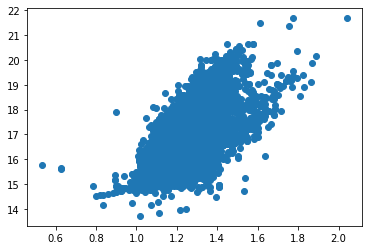

In [41]:
plt.scatter(np.log(data.area_per_room), np.log(data.price))
data['logarea_per_room'] = np.log(data.area_per_room)

In [42]:
from sklearn.linear_model import Lasso
import optuna


features = ['area_total', 'latlong', 'logarea_per_room', 'floor', 'park_distance', 'metro_distance', 'square_distance', 'rooms', 'district_enc']
X, y = data[features], np.log(data.price/data.area_total)

lasso_study = optuna.create_study(direction="minimize", study_name="Lasso Regressor")
func = lambda trial: objective_lasso(trial, X, y, area)
lasso_study.optimize(func, n_trials=100)

[I 2021-11-02 19:30:47,169] A new study created in memory with name: Lasso Regressor
[I 2021-11-02 19:30:47,491] Trial 0 finished with value: 0.32816256745370953 and parameters: {'alpha': 0.29852353274510274}. Best is trial 0 with value: 0.32816256745370953.
[I 2021-11-02 19:30:47,630] Trial 1 finished with value: 0.3034954363879413 and parameters: {'alpha': 0.009303360675772506}. Best is trial 1 with value: 0.3034954363879413.
[I 2021-11-02 19:30:47,807] Trial 2 finished with value: 0.2986452338854855 and parameters: {'alpha': 0.00017965204955131816}. Best is trial 2 with value: 0.2986452338854855.
[I 2021-11-02 19:30:48,014] Trial 3 finished with value: 0.2985666741250205 and parameters: {'alpha': 1.4366855354744135e-05}. Best is trial 3 with value: 0.2985666741250205.
[I 2021-11-02 19:30:48,172] Trial 4 finished with value: 0.30060830935184385 and parameters: {'alpha': 0.0017008353637699889}. Best is trial 3 with value: 0.2985666741250205.
[I 2021-11-02 19:30:48,407] Trial 5 finishe

In [43]:
lasso_mod = Lasso(**lasso_study.best_params)
lasso_mod.fit(data[features], np.log(data.price/data.area_total))

array([ 1.17871803e-03,  7.64039820e-04,  8.43982690e-01,  3.15934021e-03,
       -3.80962009e-06,  3.05365744e-05, -3.48768131e-05,  1.52866413e-02,
        4.74035015e-02])

In [164]:
preds = np.exp(lasso_mod.predict(data_test[features])) * data_test.area_total

submission = pd.DataFrame()
submission['id'] = data_test.id
submission['price_prediction'] = preds
submission.to_csv('submissions/lasso_sub.csv', index=False